In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (20,7)

In [2]:
countries_mapping = {
    "134": "Germany",
    "111": "UnitedStates",
    "132": "France",
    "193": "Australia",
    "156": "Canada",
    "112": "UnitedKingdom",
    "122": "Austria",
    "124": "BelgiumLuxembourg",
    "138": "NetherlandsThe",
    "136": "Italy",
    "124": "Belgium",
    "128": "Denmark",
    "142": "Norway",
    "144": "Sweden",
    "146": "Switzerland",
    "158": "Japan",
    "174": "Greece",
    "172": "Finland",
    "184": "Spain",
    "178": "Ireland",
    "182": "Portugal"
}

list_countries = ["Germany", "UnitedStates", "France", "Australia", "Canada", "UnitedKingdom", 
 "Austria", "Italy", 
 "Denmark", "Norway", "Sweden", "Switzerland", "Japan", "Greece", 
 "Finland", "Spain", "Ireland", "Portugal"]

In [3]:
def clean_trade_dataset(df):
    """
    Takes the df as provided by the imf and returns it as a clean and usable dataframe
    """
    df_transposed = df.iloc[5:,1:].T
    df_transposed.columns = df_transposed.iloc[0]
    df_transposed = df_transposed.iloc[1:, :]
    df_transposed.rename(columns={np.nan: "Year"}, inplace=True)
    df_transposed["Year"] = df_transposed["Year"].astype("int")
    df_transposed = df_transposed.set_index("Year")
    return df_transposed

def process_nominal_GDP(df):
    df = df.set_index("Year")
    df = df.replace("...", np.nan)
    for column in df.columns:
        df = df.astype({column:'float'})
    df = df.rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
    })
    return df.loc[1960:]

def process_real_GDP(df):
    df.columns = df.loc["Country"]
    df = (
        df
        .iloc[3:, ]
        .replace("...", np.nan)
        .rename(columns={
            "New Zealand": "NewZealand",
            "Netherlands, The": 'NetherlandsThe',
            "United States": "UnitedStates",
            "United Kingdom": "UnitedKingdom",
        })
    )

    for column in df.columns:
        df[column] = df[column].str.replace(" ","")
        df = df.astype({column:'float'})
    
    df = df.rename(columns={"Country": "date"})
    df["year"] = df.index.str[:4].astype(int)
    df["quarter"] = df.index.str[4:]
    df["month"] = df["quarter"].replace({"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10})
    df['date'] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))
    df = df.set_index("date")
    return df

def get_trade_activity(country_i, country_j):
    """
    Takes 2 countries as input
    Returns a dataframe with trade activity between these two countries
    X_i_j: export from country i to j
    X_i: total global export from country i
    M_i_j: import of country i from j
    M_i: total global import of country i
    Y_i: GDP of country i
    """
    X_i_j = dict_export[country_i][[country_j]].rename(columns={country_j: f"Export from {country_i} to {country_j}"})
    X_i = dict_export[country_i][["World"]].rename(columns={"World": f"Global Export from {country_i} to world"})
    X_j = dict_export[country_j][["World"]].rename(columns={"World": f"Global Export from {country_j} to world"})
    M_i_j = dict_import[country_i][[country_j]].rename(columns={country_j: f"Import of {country_i} from {country_j}"})
    M_i = dict_import[country_i][["World"]].rename(columns={"World": f"Global Import of {country_i}"})
    M_j = dict_import[country_j][["World"]].rename(columns={"World": f"Global Import of {country_j}"})
    Y_real_i = real_GDP_yearly[[country_i]].rename(columns={country_i: f"GDP of {country_i}"})
    Y_real_j = real_GDP_yearly[[country_j]].rename(columns={country_j: f"GDP of {country_j}"})
    Y_nominal_i = nominalGDP[[country_i]].rename(columns={country_i: f"GDP of {country_i}"})
    Y_nominal_j = nominalGDP[[country_j]].rename(columns={country_j: f"GDP of {country_j}"})
    W_i_j = pd.concat([X_i_j, X_i, M_i_j, M_i, X_j, M_j, Y_real_i, Y_real_j,Y_nominal_i, Y_nominal_j], axis=1)
    W_i_j["wt: Trade Intensity by bilateral trade"] = (X_i_j.values + M_i_j.values) / (X_i.values + X_j.values + M_i.values + M_j.values)
    W_i_j["wy_real: Trade Intensity by real GDP"] = (X_i_j.values + M_i_j.values) / (Y_real_i.values + Y_real_j.values)
    W_i_j["wy_nominal: Trade Intensity by nominal GDP"] = (X_i_j.values + M_i_j.values) / (Y_nominal_i.values + Y_nominal_j.values)
    W_i_j["wm"] = M_i_j.values / (M_i.values + M_j.values)
    W_i_j["wx"] = X_i_j.values / (X_i.values + X_j.values)
    for column in W_i_j.columns:
        W_i_j[column] = W_i_j[column].astype(float)
    return W_i_j

def get_average_period(df_trade_activity, date1, date2, country_i, country_j):
    ta_ci_cj = df_trade_activity[country_i][country_j]
    ta_ci_cj = ta_ci_cj[(ta_ci_cj.index >= date1) & (ta_ci_cj.index <= date2)]
    ta_ci_cj = ta_ci_cj.sort_index()
    return np.abs(pd.DataFrame(
                ta_ci_cj[["wt: Trade Intensity by bilateral trade",
                          "wy_real: Trade Intensity by real GDP",
                          "wy_nominal: Trade Intensity by nominal GDP",
                          "wm",
                          "wx"]]).loc[date1:date2].mean()).T

def process_concept_data(df):
    df = df[["Value", "TIME", "Country"]]
    df["Value"] = np.log(df["Value"])
    df["Year"] = df["TIME"].astype(str).str[:4]
    df["Quarter"] = df["TIME"].astype(str).str[-1].astype(int)
    df["Month"] = (df["Quarter"]-1)*3+1
    df['Date'] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1))
    return df

Process:
For the economic concepts (left side of regression equation: real GDP, employment, unemployment):
-> de-trend data with 4 methods (so far HP filter and 4th lag)
-> get correlation at each quarter between each pair of countries available)
-> aggregate correlation to get mean over each period (4 periods)

For the bilateral trade intensity (right side of the regression equation, based on nominal GDP):
-> Get bilateral trade concept (wx, wm, wt) between each pair of countries available
-> Get average over each period


In [4]:
path_nominal_GDP = "data_StatApp/imf/NominalGDP.xls"
xls_nominalGDP = pd.ExcelFile(path_nominal_GDP)
nominalGDP = pd.read_excel(xls_nominalGDP, 'Sheet1')

path_real_GDP = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/imf/real_GDP_corrected.csv"
real_GDP = pd.read_csv(path_real_GDP, on_bad_lines='skip').T

In [5]:
nominalGDP.head()

,Year,"Afghanistan, Islamic Rep. of",Albania,Algeria,"Andorra, Principality of",Angola,Anguilla,Antigua and Barbuda,Argentina,"Armenia, Rep. of","Aruba, Kingdom of the Netherlands",Australia,Austria,"Azerbaijan, Rep. of","Bahamas, The","Bahrain, Kingdom of",Bangladesh,Barbados,"Belarus, Rep. of",Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Cayman Islands,Central African Rep.,Chad,Chile,"China, P.R.: Hong Kong","China, P.R.: Macao","China, P.R.: Mainland",Colombia,"Comoros, Union of the","Congo, Dem. Rep. of the","Congo, Rep. of",Costa Rica,Côte d'Ivoire,"Croatia, Rep. of",Cyprus,Czech Rep.,Denmark,Djibouti,Dominica,Dominican Rep.,Ecuador,"Egypt, Arab Rep. of",El Salvador,"Equatorial Guinea, Rep. of","Eritrea, The State of","Estonia, Rep. of","Eswatini, Kingdom of","Ethiopia, The Federal Dem. Rep. of",Euro Area,"Fiji, Rep. of",Finland,France,Gabon,"Gambia, The",Georgia,Germany,Ghana,Greece,Grenada,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Honduras,Hungary,Iceland,India,Indonesia,"Iran, Islamic Rep. of",Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,"Kazakhstan, Rep. of",Kenya,Kiribati,"Korea, Rep. of","Kosovo, Rep. of",Kuwait,Kyrgyz Rep.,Lao People's Dem. Rep.,Latvia,Lebanon,"Lesotho, Kingdom of",Liberia,Libya,Lithuania,Luxembourg,"Madagascar, Rep. of",Malawi,Malaysia,Maldives,Mali,Malta,"Marshall Islands, Rep. of the","Mauritania, Islamic Rep. of",Mauritius,Mexico,"Micronesia, Federated States of","Moldova, Rep. of",Mongolia,Montenegro,Montserrat,Morocco,"Mozambique, Rep. of",Myanmar,Namibia,"Nauru, Rep. of",Nepal,"Netherlands, The",New Zealand,Nicaragua,Niger,Nigeria,"North Macedonia, Republic of",Norway,Oman,Pakistan,"Palau, Rep. of",Panama,Papua New Guinea,Paraguay,Peru,Philippines,"Poland, Rep. of",Portugal,Romania,Russian Federation,Rwanda,Samoa,"San Marino, Rep. of","São Tomé and Príncipe, Dem. Rep. of",Saudi Arabia,Senegal,"Serbia, Rep. of",Seychelles,Sierra Leone,Singapore,Slovak Rep.,"Slovenia, Rep. of",Solomon Islands,Somalia,South Africa,"South Sudan, Rep. of",Spain,Sri Lanka,St. Kitts and Nevis,St. Lucia,St. Vincent and the Grenadines,Sudan,Suriname,Sweden,Switzerland,Syrian Arab Rep.,"Tajikistan, Rep. of","Tanzania, United Rep. of",Thailand,"Timor-Leste, Dem. Rep. of",Togo,Tonga,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,Tuvalu,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,"Uzbekistan, Rep. of",Vanuatu,Vietnam,West Bank and Gaza,"Yemen, Rep. of",Zambia,Zimbabwe
0,1959,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,42263,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,2173.308892,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,521654.3,...,...,...,...,...,...,...,...
1,1960,...,...,...,...,...,...,...,...,...,...,17313,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,46834,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,249870,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,2323.267311,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [6]:
nominalGDP = process_nominal_GDP(nominalGDP)
real_GDP = process_real_GDP(real_GDP)
real_GDP_yearly = real_GDP.groupby("year").sum()

real_GDP_yearly = real_GDP_yearly.loc[1960:2020]

real_GDP_yearly = real_GDP_yearly.replace(0.0, np.nan)

real_GDP = real_GDP[list_countries]

real_GDP_yearly.head()

Country,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,"China, P.R.: Hong Kong",Colombia,Costa Rica,"Croatia, Rep. of",Cyprus,Czech Rep.,Denmark,Ecuador,El Salvador,"Estonia, Rep. of",Euro Area,Finland,France,Germany,Greece,Honduras,Hungary,India,Indonesia,Ireland,Israel,Italy,Japan,Jordan,"Korea, Rep. of",Latvia,Lithuania,Luxembourg,Malta,Mexico,"Moldova, Rep. of",NetherlandsThe,NewZealand,Norway,Philippines,"Poland, Rep. of",Portugal,Romania,Russian Federation,Saudi Arabia,"Serbia, Rep. of",Singapore,Slovak Rep.,"Slovenia, Rep. of",South Africa,Spain,Sweden,Switzerland,Thailand,Turkey,Ukraine,UnitedKingdom,UnitedStates,month
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,NaN,277471.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29070100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,576144.0,3262061.2,22
1961,NaN,277569.0,NaN,NaN,NaN,NaN,355591.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31086500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591529.0,3345690.3,22
1962,NaN,292573.0,NaN,NaN,NaN,NaN,381995.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32297200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,597893.0,3550683.8,22
1963,NaN,310885.0,NaN,NaN,NaN,NaN,402430.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35210600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,626797.0,3705317.8,22
1964,NaN,329918.0,NaN,NaN,NaN,NaN,429163.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38546500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,662544.0,3918790.9,22


## Trade activity

#### For each country, aggregation of import and export with all other countries available

In [7]:

dict_paths = {}
dict_xls = {}
# dict export contains a set per country, representing the exports from this country to partners
dict_export = {}
# dict import contains a set per country, representing the imports of this country from partners
dict_import = {}

for country in list_countries:
    dict_paths[country] = f"data_StatApp/imf/trade/{country}.xls"
    dict_xls[country] = pd.ExcelFile(dict_paths[country])
    dict_export[country] = pd.read_excel(dict_xls[country], dict_xls[country].sheet_names[0], index_col=None)
    dict_export[country] = clean_trade_dataset(dict_export[country])\
                            .rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
    })
    dict_export[country] = dict_export[country].T.drop_duplicates().T
    dict_import[country] = pd.read_excel(dict_xls[country], dict_xls[country].sheet_names[1], index_col=None)
    dict_import[country] = clean_trade_dataset(dict_import[country])\
                            .rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
    })
    dict_import[country] = dict_import[country].T.drop_duplicates().T
    for column in dict_import[country].columns:
        dict_import[country][column] = dict_import[country][column].astype("float")
        dict_import[country][column] = dict_import[country][column].round(2)


WARNING *** file size (510790) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (536840) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (529451) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (528008) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (508973) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size 

#### For each pair of countries, aggregate all the trade activity informations

In [8]:
trade_activity_countries = {}
for country_i in list_countries:
    trade_activity_countries[country_i] = {}
    for country_j in list_countries:
        if country_i != country_j:
            ta_ci_cj = dict()
            trade_activity_countries[country_i][country_j] = get_trade_activity(country_i, country_j)
            for month in [1, 4, 7, 10]:
                ta_ci_cj[month] = trade_activity_countries[country_i][country_j] / 4
                ta_ci_cj[month]["month"] = month
            trade_activity_countries[country_i][country_j] = pd.concat([ta_ci_cj[month] for month in [1, 4, 7, 10]])
            trade_activity_countries[country_i][country_j]['Date'] = pd.to_datetime(dict(year=trade_activity_countries[country_i][country_j].index, month=trade_activity_countries[country_i][country_j]["month"], day=1))
            trade_activity_countries[country_i][country_j] = trade_activity_countries[country_i][country_j].set_index("Date")
            

#### Aggregate all trading information in the same format as Frankel Rose data

In [9]:
dy_df = pd.DataFrame(columns=["country_1", "country_2", "period"])
trade_activity_countries_split = {}

for country_i in list_countries:
    trade_activity_countries_split[country_i] = {}
    for country_j in list_countries:
        if country_i != country_j:
            for (period, date1, date2) in [(1, "1959-01-01", "1967-07-01"), (2, "1967-10-01", "1976-04-01"), (3, "1976-07-01", "1985-01-01"), (4, "1985-04-01", "1993-10-01")]:
                df_countries_ij = pd.DataFrame(data={"country_1": [country_i], "country_2": [country_j], "period": [period]})
                df_countries_ij[["wt", "wy_real", "wy_nominal", "wm", "wx"]] = get_average_period(trade_activity_countries, date1, date2, country_i, country_j)[["wt: Trade Intensity by bilateral trade", "wy_real: Trade Intensity by real GDP", "wy_nominal: Trade Intensity by nominal GDP", "wm", "wx"]]
                dy_df = pd.concat([dy_df, df_countries_ij])


In [10]:
dy_df.head()

,country_1,country_2,period,wt,wy_real,wy_nominal,wm,wx
0,Germany,UnitedStates,1,0.010454,NaN,NaN,0.013982,0.007498
0,Germany,UnitedStates,2,0.009581,NaN,0.001247,0.009372,0.009796
0,Germany,UnitedStates,3,0.007467,NaN,0.001467,0.006893,0.008163
0,Germany,UnitedStates,4,0.007967,0.001123,0.001653,0.006251,0.010009
0,Germany,France,1,0.016895,NaN,NaN,0.016686,0.017109


### Comparison with Frankel Rose data

In [11]:
FR_data_path = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/Data_FrankelRose.csv"
FR_data = pd.read_csv(FR_data_path)

In [12]:
FR_data["count1"] = FR_data["count1"].astype(str)
FR_data["count2"] = FR_data["count2"].astype(str)
FR_data["count1"] = FR_data["count1"].replace(countries_mapping)
FR_data["count2"] = FR_data["count2"].replace(countries_mapping)
FR_data = FR_data.rename(columns={"count1": "country_1", "count2": "country_2"})

In [13]:
FR_data.head()

,period,country_1,country_2,dy,di,de,du,ty,ti,te,tu,hy,hi,he,hu,sy,si,se,su,oy,oi,oe,ou,oilpxmy,doilpxmy,wx,wm,wt,c1pop,c2pop,c1rgdpch,c2rgdpch,lwt,lwx,lwm,dlwt,ddy,ddi,dde,ddu,dty,dti,dte,dtu,dhy,dhi,dhe,dhu,dsy,dsi,dse,dsu
0,1,UnitedStates,UnitedKingdom,-0.085669,0.070814,-0.102476,-0.073445,0.434204,0.403422,-0.709020,0.831643,-0.092100,-0.043734,0.268915,0.010287,0.202187,0.040077,0.234825,0.004616,-0.127651,-0.205753,0.596627,0.770944,0.000554,0.000056,0.063912,0.061481,0.062750,188532.70,53617.9100,10834.69,7267.1709,-2.768591,-2.750245,-2.789030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,UnitedStates,UnitedKingdom,0.651810,0.618985,0.485638,0.450000,0.560324,0.788419,0.519007,-0.066226,0.743788,0.739684,0.552337,0.561581,0.775855,0.744350,0.530727,0.559785,0.609409,0.714449,0.496574,0.292697,0.085774,1.120762,0.055754,0.049371,0.052393,208734.00,55852.7110,13485.14,8893.9141,-2.948975,-2.886801,-3.008402,-0.180384,0.737479,0.548171,0.588114,0.523445,0.126120,0.384996,1.228027,-0.897869,0.835888,0.783419,0.283421,0.551294,0.573669,0.704273,0.295902,0.555169
2,3,UnitedStates,UnitedKingdom,0.489485,0.380340,0.731714,0.537802,0.793406,0.608886,0.812848,0.733142,0.574553,0.386985,0.852770,0.651506,0.631670,0.431305,0.799628,0.648825,0.565606,0.474865,0.923205,0.707039,-0.069624,0.003535,0.058016,0.050574,0.053977,228449.30,56304.8590,15362.97,10267.6300,-2.919197,-2.847043,-2.984320,0.029777,-0.162325,-0.238645,0.246076,0.087801,0.233081,-0.179532,0.293841,0.799368,-0.169235,-0.352699,0.300434,0.089924,-0.144185,-0.313045,0.268902,0.089040
3,4,UnitedStates,UnitedKingdom,0.735773,0.690864,0.795698,0.797915,0.739944,0.915494,0.603760,0.659663,0.761292,0.837529,0.703515,0.695373,0.790715,0.824823,0.571224,0.697585,0.780641,0.933020,0.804186,0.706813,-0.014253,-0.004809,0.057168,0.042809,0.049051,248299.91,57271.8280,17577.66,12586.2600,-3.014903,-2.861754,-3.151005,-0.095706,0.246288,0.310525,0.063984,0.260113,-0.053462,0.306608,-0.209088,-0.073479,0.186740,0.450543,-0.149256,0.043867,0.159045,0.393518,-0.228404,0.048760
4,1,UnitedStates,Austria,0.536507,-0.407823,-0.673405,-0.547397,-0.352058,-0.579379,-0.870111,-0.309694,-0.098499,-0.376418,-0.438464,-0.518989,-0.031084,-0.132819,-0.235470,-0.518574,0.069868,-0.413708,0.319772,-0.047467,0.000174,0.000019,0.003921,0.004422,0.003986,188532.70,7171.0288,10834.69,5688.1138,-5.524892,-5.541332,-5.421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_compare = pd.merge(FR_data[["period", "country_1", "country_2", "wx", "wm", "wt"]], dy_df, on=["period", "country_1", "country_2"])

df_compare["pairs"] = df_compare["country_1"] + "-" + df_compare["country_2"]

In [15]:
df_compare.head()

,period,country_1,country_2,wx_x,wm_x,wt_x,wt_y,wy_real,wy_nominal,wm_y,wx_y,pairs
0,1,UnitedStates,UnitedKingdom,0.063912,0.061481,0.062750,0.009723,0.000157,NaN,0.009435,0.009990,UnitedStates-UnitedKingdom
1,2,UnitedStates,UnitedKingdom,0.055754,0.049371,0.052393,0.008825,0.000255,NaN,0.008444,0.009244,UnitedStates-UnitedKingdom
2,3,UnitedStates,UnitedKingdom,0.058016,0.050574,0.053977,0.008264,0.000650,NaN,0.007643,0.009029,UnitedStates-UnitedKingdom
3,4,UnitedStates,UnitedKingdom,0.057168,0.042809,0.049051,0.008196,0.000922,NaN,0.007213,0.009486,UnitedStates-UnitedKingdom
4,1,UnitedStates,Austria,0.003921,0.004422,0.003986,0.000636,NaN,NaN,0.000711,0.000571,UnitedStates-Austria


In [16]:
dict_map_colors = dict()
n = df_compare["pairs"].unique().shape[0]

for pair in df_compare["pairs"].unique():
    a, b, c = np.random.random(1)[0], np.random.random(1)[0], np.random.random(1)[0]
    dict_map_colors[pair] = (a, b, c)

Each color represents a pair of countries

<AxesSubplot:xlabel='wt_x', ylabel='wt_y'>

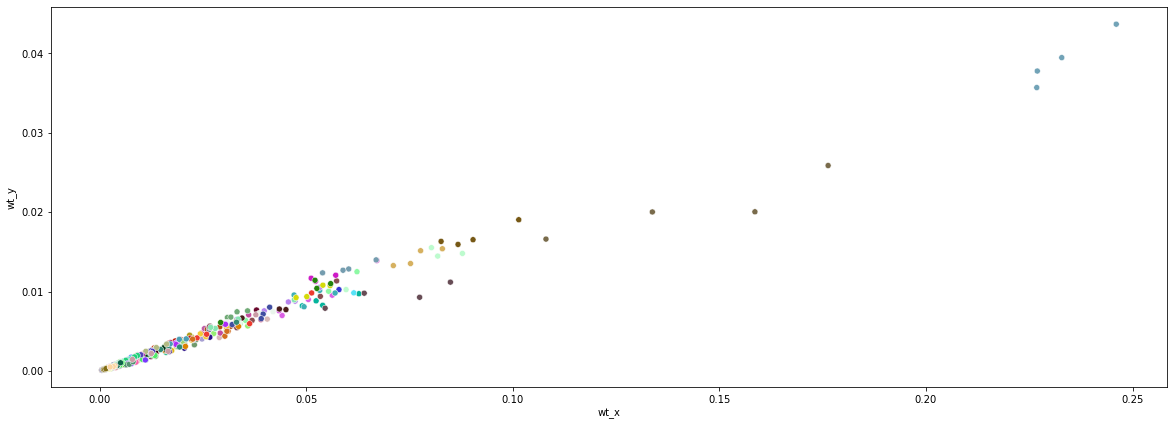

In [17]:
sns.scatterplot(data=df_compare, x="wt_x", y="wt_y", c=df_compare["pairs"].map(dict_map_colors))

<AxesSubplot:xlabel='wm_x', ylabel='wm_y'>

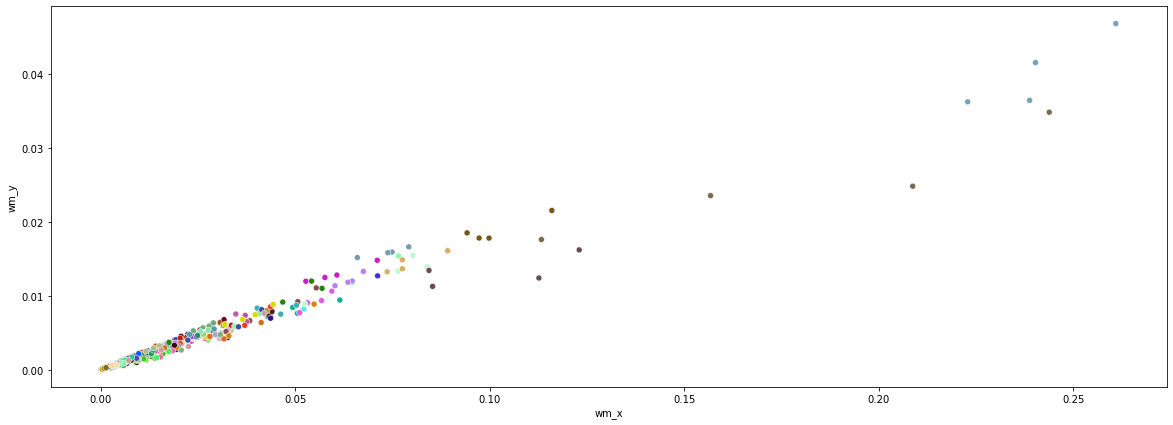

In [18]:
sns.scatterplot(data=df_compare, x="wm_x", y="wm_y", c=df_compare["pairs"].map(dict_map_colors))

<AxesSubplot:xlabel='wx_x', ylabel='wx_y'>

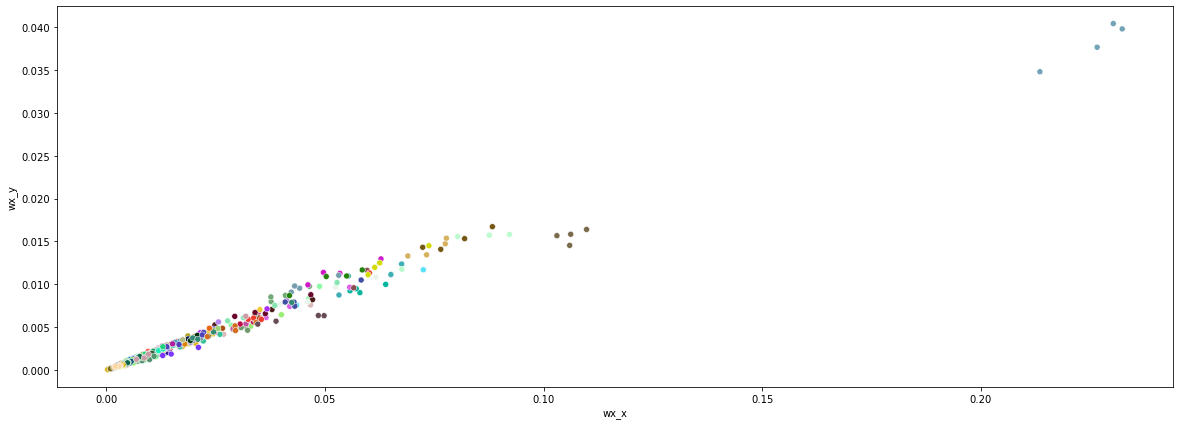

In [19]:
sns.scatterplot(data=df_compare, x="wx_x", y="wx_y", c=df_compare["pairs"].map(dict_map_colors))

#### Get correlation of data trends between processed data and Frankel Rose data

In [20]:
countries_corr = {}
for w in ["wt", "wm", "wx"]:
    countries_corr[str(w)] = dict()
    for i in range(len(list_countries)-1):
        country1 = list_countries[i]
        for j in range(i+1, len(list_countries)):
            country2 = list_countries[j]
            fr_df = FR_data[(FR_data["country_1"] == country1) & (FR_data["country_2"] == country2)][[w]]
            if fr_df.empty:
                fr_df = FR_data[(FR_data["country_1"] == country2) & (FR_data["country_2"] == country1)][[w]]
            dy_df_w = dy_df[(dy_df["country_1"] == country1) & (dy_df["country_2"] == country2)][[w]]
            countries_corr[str(w)][country1 + "_" + country2] = np.corrcoef(fr_df.values[:, 0], dy_df_w.values[:, 0])[0, 1]


#### average correlation between Frankel Rose data and processed data over all pairs of countries

In [21]:
print(f"average correlation on wt Trade Intensity by bilateral trade: {np.mean(list(countries_corr['wt'].values()))}")
print(f"average correlation on wm Trade Intensity by import: {np.mean(list(countries_corr['wx'].values()))}")
print(f"average correlation on wx Trade Intensity by export: {np.mean(list(countries_corr['wm'].values()))}")


average correlation on wt Trade Intensity by bilateral trade: 0.8863145766570252
average correlation on wm Trade Intensity by import: 0.7737402410084454
average correlation on wx Trade Intensity by export: 0.7686359168084668


## Analysis of economic concept data

### Employment data

In [24]:
employment_data_path = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/oecd/Employment.csv"
employment = pd.read_csv(employment_data_path)
employment = employment[employment["Subject"] == 'Employed population, Aged 15 and over, All persons']

In [25]:
employment = process_concept_data(employment)

/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/2320969168.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Value"] = np.log(df["Value"])
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/2320969168.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = df["TIME"].astype(str).str[:4]
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/2320969168.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [26]:
def get_aggregation_countries(df):
    df_aggregate = pd.DataFrame({"date": real_GDP.index})
    for country in df["Country"].unique():
        df_country = df[df["Country"] == country][["Date", "Value"]].rename(columns={"Value": country, "Date": "date"})
        df_aggregate = pd.merge(df_aggregate, df_country, on="date", how="left")
    return df_aggregate

In [27]:
employment = get_aggregation_countries(employment)

### Unemployment data

In [54]:
path_unemployment = "/Users/victorgraff/Documents/2022:2023 ENSAE/Cours/Statapps/data_StatApp/oecd/UnemployedPopulation.csv"
unemploy = pd.read_csv(path_unemployment)
unemploy = unemploy[unemploy["Subject"] == 'Unemployed population, Aged 15 and over, All persons']

In [55]:
unemploy = process_concept_data(unemploy)

/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/2320969168.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Value"] = np.log(df["Value"])
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/2320969168.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = df["TIME"].astype(str).str[:4]
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_647/2320969168.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [56]:
unemploy = get_aggregation_countries(unemploy).set_index("date")

In [57]:
unemploy.head()

,Australia,Austria,Belgium,Canada,Czech Republic,Denmark,Finland,France,Germany,Greece,Hungary,Iceland,Ireland,Italy,Japan,Korea,Luxembourg,Mexico,Netherlands,New Zealand,Norway,Poland,Portugal,Slovak Republic,Spain,Sweden,Switzerland,Türkiye,United Kingdom,United States,Chile,Estonia,Israel,Russia,Slovenia,G7,OECD - Total,Euro area (19 countries),Colombia,Latvia,Lithuania,Costa Rica
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,5.952377,NaN,NaN,NaN,5.733298,NaN,NaN,NaN,NaN,NaN,NaN,6.959715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.280120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-04-01,NaN,NaN,NaN,5.906270,NaN,NaN,NaN,5.711381,NaN,NaN,NaN,NaN,NaN,NaN,6.901066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.158516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-07-01,NaN,NaN,NaN,5.858885,NaN,NaN,NaN,5.692210,NaN,NaN,NaN,NaN,NaN,NaN,6.863455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.197080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-10-01,NaN,NaN,NaN,5.893484,NaN,NaN,NaN,5.675748,NaN,NaN,NaN,NaN,NaN,NaN,6.779922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.257213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-01,NaN,NaN,NaN,5.997281,NaN,NaN,NaN,5.646534,NaN,NaN,NaN,NaN,NaN,NaN,6.650710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.176579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
unemploy = unemploy.rename(columns={
        "United States": "UnitedStates",
        "United Kingdom": "UnitedKingdom",
    })
unemploy[list_countries].loc["1996-01-01":]

,Germany,UnitedStates,France,Australia,Canada,UnitedKingdom,Austria,Italy,Denmark,Norway,Sweden,Switzerland,Japan,Greece,Finland,Spain,Ireland,Portugal
date,,,,,,,,,,,,,,,,,,
1996-01-01,8.132297,8.905716,7.868471,6.632847,7.248741,7.753624,5.143558,NaN,5.298055,NaN,NaN,NaN,7.712742,6.079313,NaN,NaN,5.211859,NaN
1996-04-01,8.141108,8.897135,7.904511,6.637020,7.243751,7.757906,5.022499,NaN,5.312374,NaN,NaN,NaN,7.730468,6.099544,NaN,NaN,5.198221,NaN
1996-07-01,8.170324,8.863050,7.921017,6.663600,7.274549,7.734121,5.051302,NaN,5.260008,NaN,NaN,NaN,7.714231,6.109180,NaN,NaN,5.170436,NaN
1996-10-01,8.202807,8.878126,7.925609,6.664248,7.291588,7.709308,5.090681,NaN,5.202296,NaN,NaN,NaN,7.720166,6.112901,NaN,NaN,5.168342,NaN
1997-01-01,8.242339,8.865970,7.924963,6.667523,7.253211,7.642044,5.102310,NaN,5.262238,NaN,NaN,NaN,7.721644,6.051633,NaN,NaN,5.115189,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,7.415058,9.295937,7.777338,6.837810,7.502150,7.480428,5.548964,7.745761,5.126865,4.910690,6.180117,5.554638,7.651279,6.614368,5.407270,8.219747,5.026982,5.888381
2021-01-01,7.440010,9.205763,7.790246,6.711811,7.437305,7.422374,5.860726,7.797598,5.234892,4.958308,6.234903,5.613961,7.595890,6.583353,5.386189,8.182936,5.149133,5.854406
2021-04-01,7.374650,9.158064,7.802542,6.567408,7.373479,7.377759,5.689904,7.807864,4.987819,4.972417,6.226942,5.550916,7.600902,6.576321,5.401192,8.178048,5.171007,5.893615


In [36]:
set_countries = dict()
for country in unemploy["Country"].unique():
    set_countries[country] = unemploy[unemploy["Country"] == country]
    set_countries[country]["de"] = set_countries[country]["Value"].diff(4)
    set_countries[country]["se"] = sm.tsa.filters.hpfilter(set_countries[country]["Value"], 1600)[0]

/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_4677/4226400046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_countries[country]["de"] = set_countries[country]["Value"].diff(4)
/var/folders/2d/fpqdm5v94c5f03vyb1t2slp40000gn/T/ipykernel_4677/4226400046.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_countries[country]["se"] = sm.tsa.filters.hpfilter(set_countries[country]["Value"], 1600)[0]


In [38]:
set_countries["UnitedStates"] = set_countries.pop("United States")
set_countries["UnitedKingdom"] = set_countries.pop("United Kingdom")